In [81]:
import os
import pickle as pkl
import csv
import math
import pandas as pd

from kmapper import KeplerMapper, Cover
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

WDIRS = ['/Users/danielhasegan/workspace/netpyne-project/results/20210907-ES1500it/evaluation_0/',
    '/Users/danielhasegan/workspace/netpyne-project/results/20210907-ES1500it/evaluation_15/',
    '/Users/danielhasegan/workspace/netpyne-project/results/hpsearch-2021-09-06/best/1_run_168/evaluation_8/',]

NAMES = ['INIT', 'EVOL', 'STDP']


# wdir= '/Users/danielhasegan/workspace/netpyne-project/results/20210907-ES1500it/evaluation_0/'
# wdir= '/Users/danielhasegan/workspace/netpyne-project/results/20210907-ES1500it/evaluation_15/'
# wdir= '/Users/danielhasegan/workspace/netpyne-project/results/hpsearch-2021-09-06/best/1_run_168/evaluation_8/'

LENSES = []


resolution = 49.8 / 4
offset = 49.8 * 3
N = 10000 # total_length // 5

for wdir in WDIRS:
    print(wdir)

    sim_path = os.path.join(wdir, 'sim.pkl')

    with open(sim_path, 'rb') as f:
        sim = pkl.load(f)

    total_length = math.ceil((sim['simData']['spkt'][-1] - offset) / resolution)
    num_gids = int(max(sim['simData']['spkid']) + 1)
#     N = 10000 # total_length // 5
    M = num_gids

    X = np.zeros((N, M), dtype=np.short)

    for spkt, spkid in zip(sim['simData']['spkt'], sim['simData']['spkid']):
        if spkt < offset:
            continue

        t = math.floor((spkt - offset) / resolution)
        if t >= N:
            continue
        X[t][int(spkid)] = 1

    # Generate shape graph using KeplerMapper
    mapper = KeplerMapper(verbose=1)
    lens = mapper.fit_transform(X, projection=TSNE(2, perplexity=50, random_state=1))

    LENSES.append(lens)

/Users/danielhasegan/workspace/netpyne-project/results/20210907-ES1500it/evaluation_0/
KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: TSNE(perplexity=50, random_state=1)
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (10000, 200)

..Projecting data using: 
	TSNE(perplexity=50, random_state=1, verbose=1)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.557s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed condi

In [83]:
MOT_OUTS = []


for wdir in WDIRS:
    mot_path = os.path.join(wdir, 'MotorOutputs.txt')
    
    with open(mot_path) as f:
        mot_rews = [line for line in csv.reader(f, delimiter='\t')]

    y = np.zeros(N, dtype=np.short)

    for idx, row in enumerate(mot_rews):
        if float(row[0]) < offset:
            continue
        tstart = math.floor((float(row[0]) - offset) / resolution)

        if idx < len(mot_rews) - 1:
            tnext = math.floor((float(mot_rews[idx+1][0]) - offset) / resolution)
        else:
            tnext = N

        lmove, rmove = float(row[1]), float(row[2])
        move = 1 if lmove == rmove else (2 if lmove > rmove else 3)

        for t in range(tstart, tnext):
            if t >= N:
                continue
            y[t] = move
            
    MOT_OUTS.append(y)

INIT
EVOL
STDP


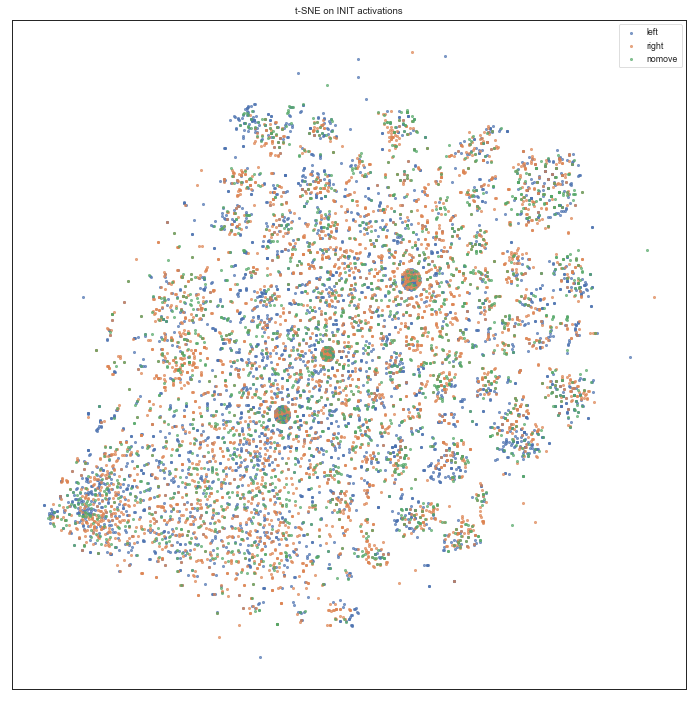

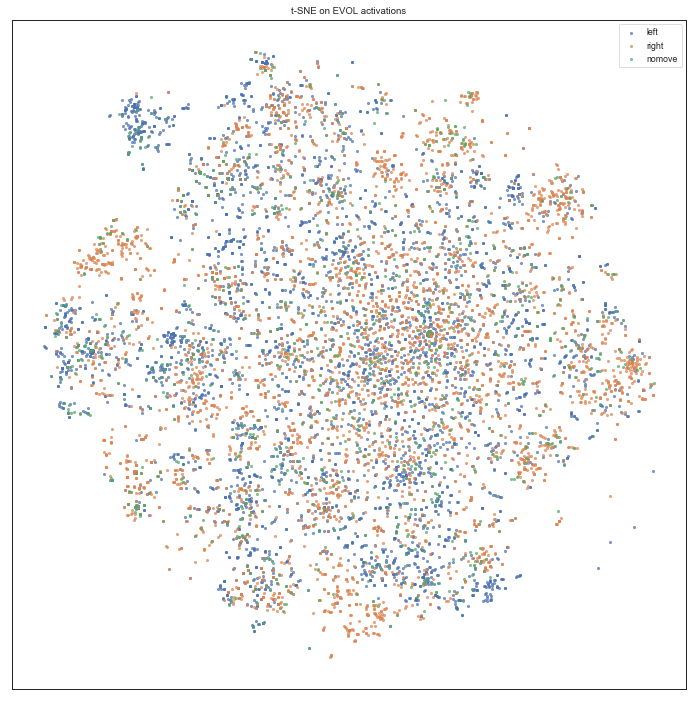

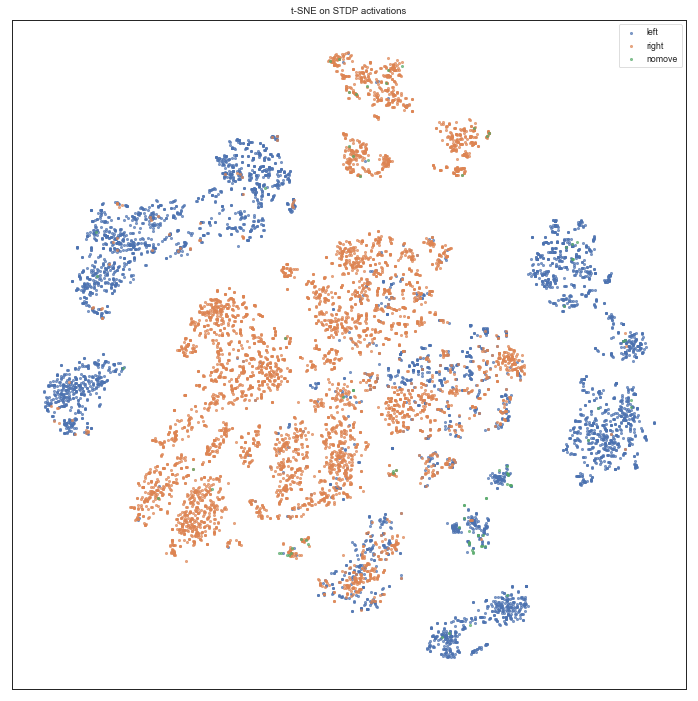

In [84]:
for wdir, name, lens, y in zip(WDIRS, NAMES, LENSES, MOT_OUTS):
    print(name)

    plt.figure(figsize=(10,10))

    L = []

    for i in [2,3,1]:
        plt.scatter(lens[y == i][:,0], lens[y == i][:,1], 5, alpha=0.7)
        L.append(['nomove', 'left', 'right'][i-1])

    plt.title('t-SNE on {} activations'.format(name))
    plt.tight_layout()

    plt.legend(L)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('tSNE-{}.png'.format(name.lower()), dpi=300)

In [96]:
ACTS_EPS = []

# EPS_INTERVALS = [
#     [0, 20],
#     [20, 30],
#     [30, 40],
#     [40, 60],
#     [60, 100],
#     [100, 150],
#     [150, 200],
#     [200, 300],
#     [300, 501]]

EPS_INTERVALS = [
    [0, 50],
    [50, 100],
    [100, 200],
    [200, 501]]


for wdir in WDIRS:
    acts_path = os.path.join(wdir, 'ActionsPerEpisode.txt')
    
    with open(acts_path) as f:
        acts = [int(float(line[1])) for line in csv.reader(f, delimiter='\t')]

    y = np.zeros(N, dtype=np.short)
    
    current_eps = 0
    for idx, eps in enumerate(acts):
        interval_idx = [i for i,(s,e) in enumerate(EPS_INTERVALS) if s <= eps and eps < e][0]
        
        tstart = current_eps
        tend = tstart + eps  + (-3 if idx == 0 else 0)

        for t in range(tstart, tnext):
            if t >= N:
                continue
            y[t] = interval_idx
            
        current_eps = tend
            
    ACTS_EPS.append(y)

INIT
EVOL
STDP


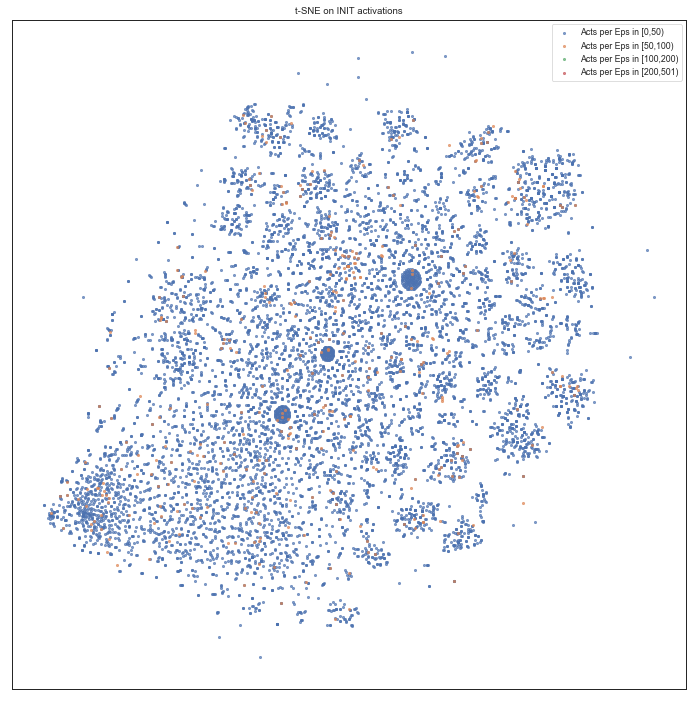

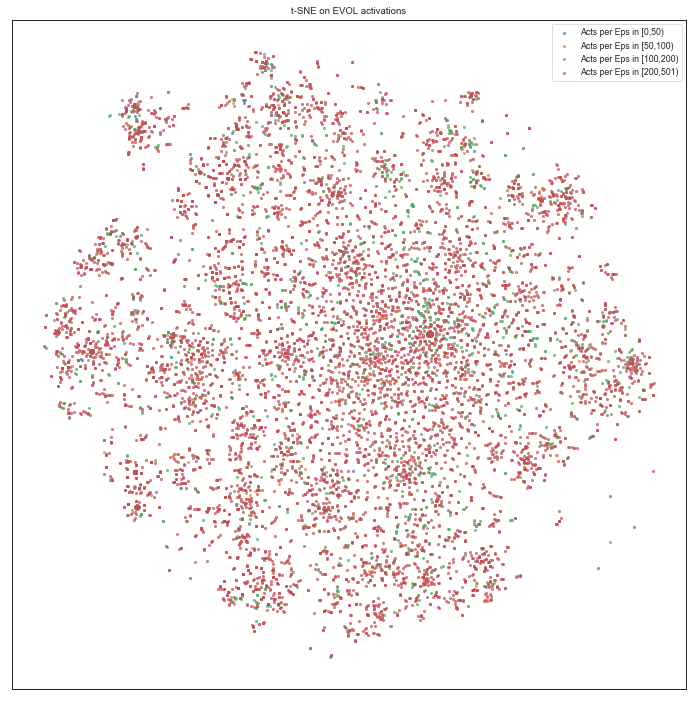

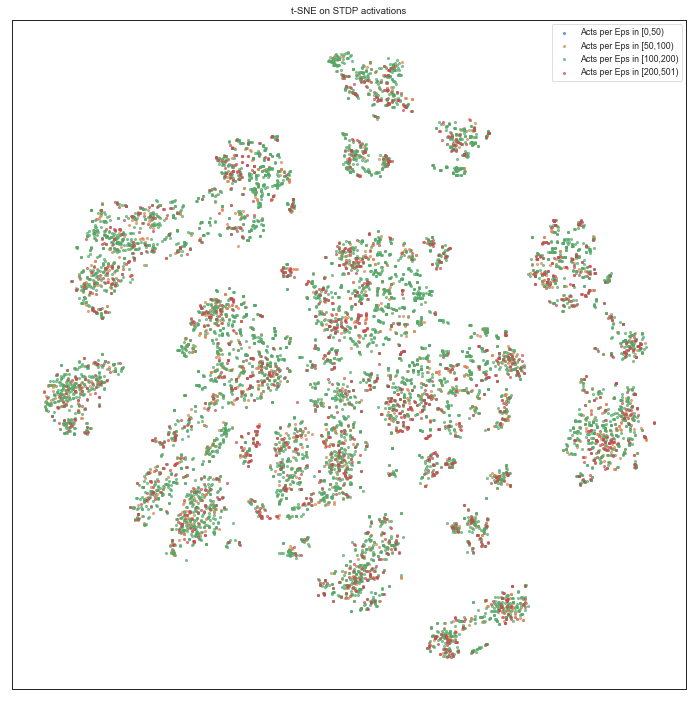

In [97]:
for wdir, name, lens, y in zip(WDIRS, NAMES, LENSES, ACTS_EPS):
    print(name)

    plt.figure(figsize=(10,10))

    L = []

    for i,(s,e) in enumerate(EPS_INTERVALS):
        plt.scatter(lens[y == i][:,0], lens[y == i][:,1], 5, alpha=0.7)
        L.append('Acts per Eps in [{},{})'.format(s,e))

    plt.title('t-SNE on {} activations'.format(name))
    plt.tight_layout()

    plt.legend(L)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('tSNE_actseps-{}.png'.format(name.lower()), dpi=300)

(array([4820., 2334., 1785.,  758.,  367.,  328.,  400.,  347.,  123.,
           9.]),
 array([4.2810484e-09, 6.1904613e-02, 1.2380922e-01, 1.8571383e-01,
        2.4761844e-01, 3.0952305e-01, 3.7142766e-01, 4.3333226e-01,
        4.9523687e-01, 5.5714148e-01, 6.1904609e-01], dtype=float32),
 <a list of 10 Patch objects>)

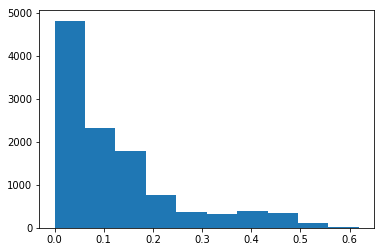

In [6]:
import matplotlib.pyplot as plt

d = np.sum((lens[1:] - lens[:-1]) ** 2, axis=1)

plt.hist(d)

In [25]:
graph = mapper.map(lens, X, cover=Cover(10, 0.8), clusterer=DBSCAN(eps=10.0))

Mapping on data shaped (11272, 200) using lens shaped (11272, 2)

Creating 100 hypercubes.

Created 2400 edges and 100 nodes in 0:00:27.833236.


In [28]:
from dyneusr import DyNeuGraph

# Visualize the shape graph using DyNeuSR's DyNeuGraph                          
dG = DyNeuGraph(G=graph, y=y)
dG.visualize('dyneusr_stdp_p50.html')


label,group,value,row_count
meta-column-0,0,28527,11272


KeyboardInterrupt: 

label,group,value,row_count
meta-column-0,0,28527,11272


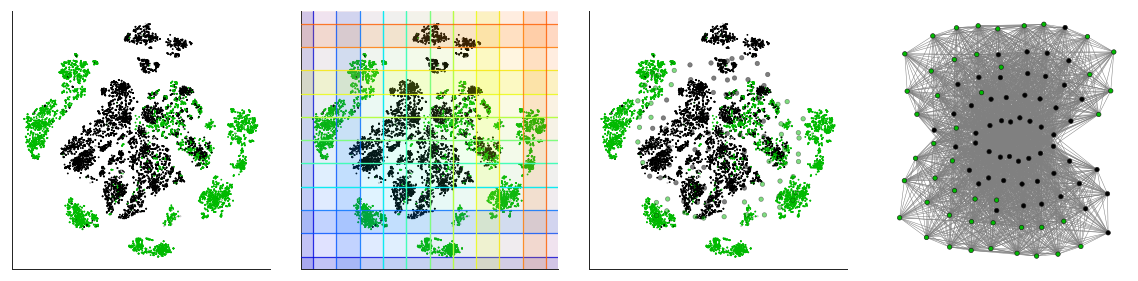

In [30]:
from dyneusr.tools import visualize_mapper_stages

fig, axes = visualize_mapper_stages(
    X, y=y, lens=lens, graph=graph, cover=mapper.cover,
    node_size=20, edge_size=0.5, edge_color='gray',
    layout="kamada_kawai",  figsize=(16, 4)
    )

plt.savefig('tSNE-stdp.png', dpi=300)
plt.show()

In [40]:
lens[y == 1][:,0]

array([0.5213928 , 0.8163247 , 0.5994    , 0.6597172 , 0.43386087,
       0.6584552 , 0.53947353, 0.443068  , 0.6692797 , 0.80774504,
       0.6042079 , 0.6248089 , 0.521865  , 0.8163686 , 0.6025047 ,
       0.66005373, 0.78942525, 0.9169141 , 0.5946189 , 0.87501156,
       0.28241867, 0.55209255, 0.29295313, 0.28336656, 0.65199125,
       0.7917956 , 0.50289893, 0.61347955, 0.6261286 , 0.81023306,
       0.6341151 , 0.63062304, 0.02233475, 0.23869172, 0.1999161 ,
       0.05246016, 0.41929743, 0.55659246, 0.41996852, 0.4166214 ,
       0.5219518 , 0.8166332 , 0.59964406, 0.6329514 , 0.6692608 ,
       0.8054301 , 0.60425293, 0.6250299 , 0.80083674, 0.8074062 ,
       0.60347784, 0.6464752 , 0.91424584, 0.9177084 , 0.49370053,
       0.919407  , 0.5006477 , 0.6918    , 0.53681767, 0.51777196,
       0.8471713 , 0.91512316, 0.5308952 , 0.879255  , 0.47662953,
       0.71094716, 0.5151372 , 0.49865294, 0.5198371 , 0.715124  ,
       0.50555986, 0.48808494, 0.30495206, 0.36889684, 0.29095